In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv

In [2]:
url = 'https://raw.githubusercontent.com/Jneny/Hospitalcapacity/main/Data/icu_beds.csv'
data = read_csv(url, header=0, parse_dates=[0], index_col=0)
data = data.asfreq('d')
adultcrit = pd.DataFrame(data, columns=['adult_icu_crci_patients'])
sadultcrit = pd.Series(adultcrit.adult_icu_crci_patients)

In [3]:
size = int(len(adultcrit)*.8)
adtrain = adultcrit.iloc[:size]
adtest = adultcrit.iloc[size:]

In [4]:
#from statsmodels.tsa.seasonal import seasonal_decompose

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#convert dataset to scale of 0 to 1/ normalize because do not want magnitude to get confused due to different ranges of magnitude

In [15]:
scaler.fit(adtrain)
scaled_train = scaler.transform(adtrain)
scaled_test = scaler.transform(adtest)

In [16]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
#Define generator
#feeding values to NN to create batches to predict next time range
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size =1)

In [18]:
X,y = generator[0]
print(f'Given the Arrary: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Arrary: 
[0.25947187 0.25028703 0.26176808]
Predict this y: 
 [[0.25832377]]


In [19]:
X.shape

(1, 3, 1)

In [20]:
#Do it for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size =1)

In [25]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import LSTM

In [27]:
# Define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss = 'mse')

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [29]:
#fit model
model.fit(generator, epochs=50)

Epoch 1/50
512/512 [==============================] - 3s 3ms/step - loss: 0.0041
Epoch 2/50
512/512 [==============================] - 2s 4ms/step - loss: 0.0011
Epoch 3/50
512/512 [==============================] - 2s 4ms/step - loss: 5.6076e-04
Epoch 4/50
512/512 [==============================] - 2s 3ms/step - loss: 4.7922e-04
Epoch 5/50
512/512 [==============================] - 2s 4ms/step - loss: 3.4126e-04
Epoch 6/50
512/512 [==============================] - 2s 4ms/step - loss: 4.2546e-04
Epoch 7/50
512/512 [==============================] - 2s 4ms/step - loss: 3.7031e-04
Epoch 8/50
512/512 [==============================] - 2s 4ms/step - loss: 2.8296e-04
Epoch 9/50
512/512 [==============================] - 2s 4ms/step - loss: 2.1888e-04
Epoch 10/50
512/512 [==============================] - 2s 4ms/step - loss: 2.9086e-04
Epoch 11/50
512/512 [==============================] - 2s 4ms/step - loss: 2.0701e-04
Epoch 12/50
512/512 [==============================] - 2s 4ms/step - lo

In [32]:
#plot loss
loss_per_epoch = model.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

TypeError: 'History' object is not subscriptable

In [33]:
last_train_batch = scaled_train[-12:]

In [35]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [36]:
model.predict(last_train_batch)

array([[0.15869223]], dtype=float32)

In [37]:
scaled_test[0]

array([0.14925373])

In [39]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(adtest)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [40]:
test_predictions

[array([0.15869223], dtype=float32),
 array([0.16045548], dtype=float32),
 array([0.1628501], dtype=float32),
 array([0.1660902], dtype=float32),
 array([0.17014179], dtype=float32),
 array([0.17504397], dtype=float32),
 array([0.18081664], dtype=float32),
 array([0.18743521], dtype=float32),
 array([0.19497976], dtype=float32),
 array([0.2035415], dtype=float32),
 array([0.21291514], dtype=float32),
 array([0.22309211], dtype=float32),
 array([0.23430693], dtype=float32),
 array([0.2466822], dtype=float32),
 array([0.26029396], dtype=float32),
 array([0.27520496], dtype=float32),
 array([0.29143542], dtype=float32),
 array([0.3088708], dtype=float32),
 array([0.32745722], dtype=float32),
 array([0.34711874], dtype=float32),
 array([0.36789], dtype=float32),
 array([0.38982785], dtype=float32),
 array([0.41297227], dtype=float32),
 array([0.4373294], dtype=float32),
 array([0.46290666], dtype=float32),
 array([0.48962116], dtype=float32),
 array([0.51743126], dtype=float32),
 array([0.

In [42]:
adtest.head()

,adult_icu_crci_patients
date,
2021-10-07,148
2021-10-08,152
2021-10-09,152
2021-10-10,151
2021-10-11,153


In [43]:
true_predictions = scaler.inverse_transform(test_predictions)

In [45]:
adtest['Predictions'] = true_predictions

C:\Users\Jneny\AppData\Local\Temp\ipykernel_6496\426780066.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adtest['Predictions'] = true_predictions


<AxesSubplot:xlabel='date'>

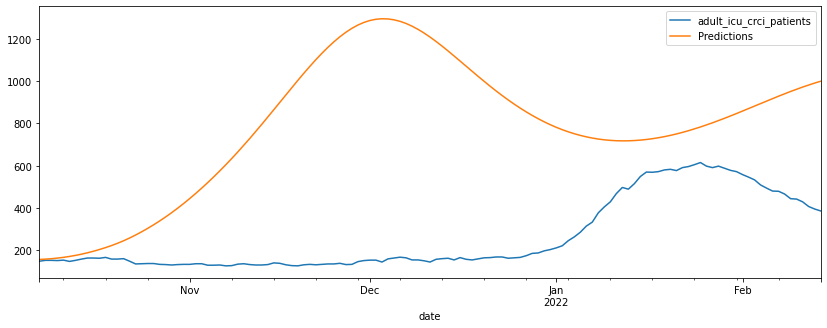

In [47]:
adtest.plot(figsize=(14,5))

In [50]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(adtest['Production'], adtest['Predictions']))
print(rmse)

KeyError: 'Production'